## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum - `np.argmin`.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [11]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/'

fileName = 'jet.bmp'
if not os.path.exists(fileName) :
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

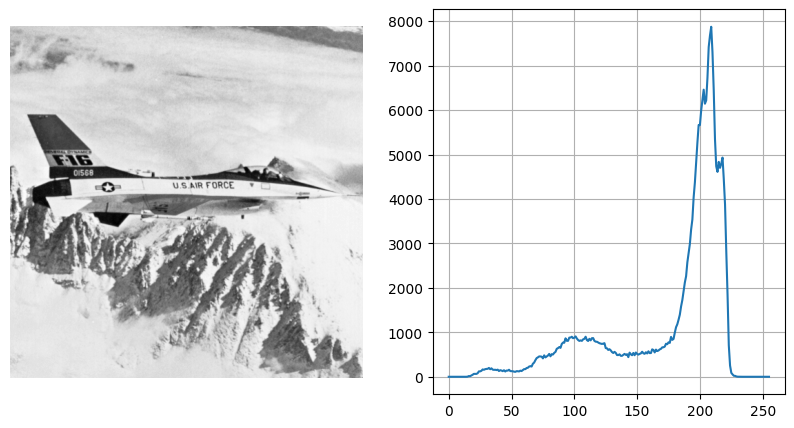

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
img = cv2.imread(fileName, cv2.IMREAD_GRAYSCALE)
hist = cv2.calcHist([img], [0], None, [256], [0,256])
axs[0].imshow(img, cmap='gray')
axs[0].axis('off')
axs[1].plot(hist)
axs[1].grid()

In [13]:
def transform_img(hist, lm):
    H1 = hist[:lm]
    H2 = hist[lm:]
    
    H1_cum = np.cumsum(H1)
    H2_cum = np.cumsum(H2)
    
    C1 = H1_cum / H1_cum.max()
    C2 = H2_cum / H2_cum.max()

    C1n = (lm * C1).astype(np.uint8)
    C2n = (lm + 1 + (255 - lm - 1) * C2).astype(np.uint8)
    LUT = np.concatenate((C1n, C2n))

    return cv2.LUT(img, LUT)

In [14]:
lm_bbhe = int(np.mean(img))

hist_flat = hist.flatten()
hist_cum = np.cumsum(hist_flat)
total_pixels = hist_cum[-1]
lm_dsihe = np.argmin(np.abs(hist_cum - (total_pixels // 2)))

img_bbhe = transform_img(hist, lm_bbhe)
img_dsihe = transform_img(hist, lm_dsihe)
img_classic = cv2.equalizeHist(img)

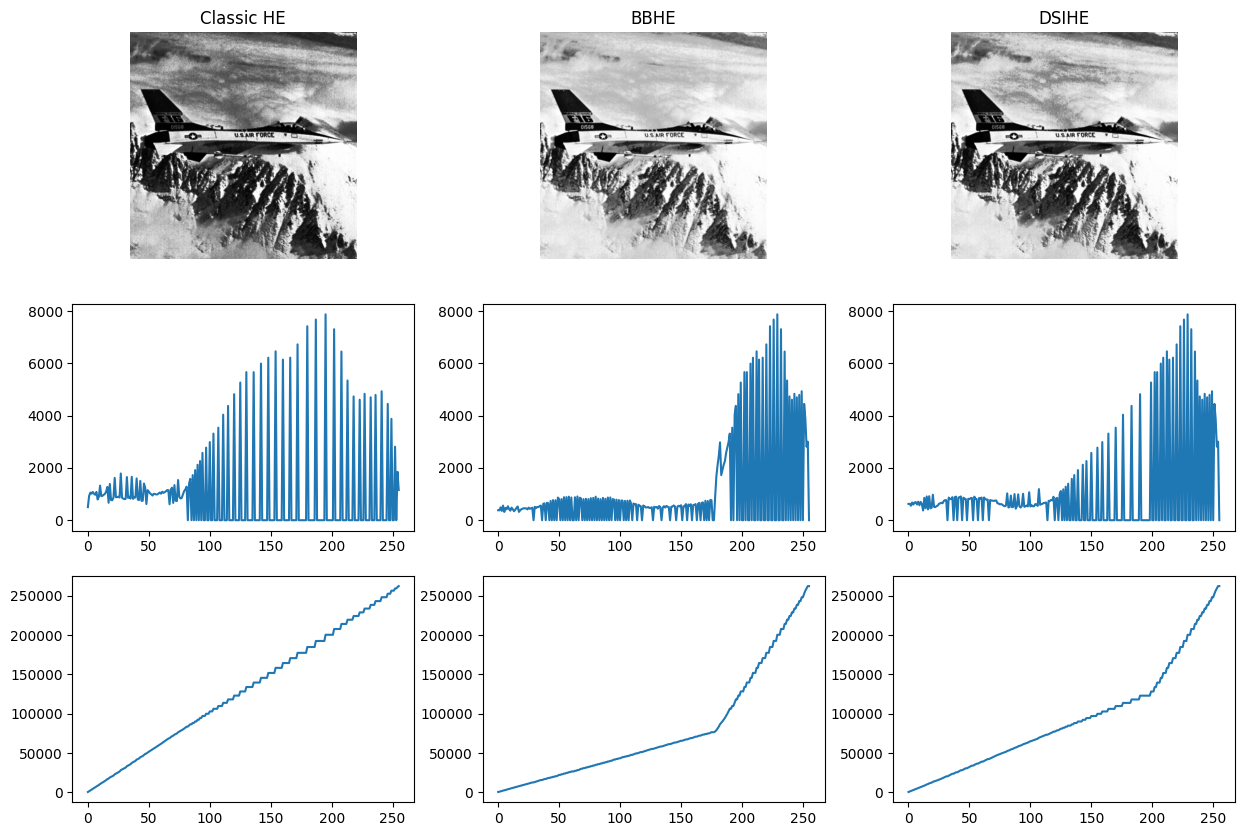

In [15]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs[0][0].imshow(img_classic, cmap='gray')
axs[0][0].set_title("Classic HE")
axs[0][0].axis("off")
hist_classic = cv2.calcHist([img_classic], [0], None, [256], [0,256])
axs[1][0].plot(hist_classic)
hist_classic_cum = np.cumsum(hist_classic)
axs[2][0].plot(hist_classic_cum)

axs[0][1].imshow(img_bbhe, cmap='gray')
axs[0][1].set_title("BBHE")
axs[0][1].axis("off")
hist_bbhe = cv2.calcHist([img_bbhe], [0], None, [256], [0,256])
axs[1][1].plot(hist_bbhe)
hist_bbhe_cum = np.cumsum(hist_bbhe)
axs[2][1].plot(hist_bbhe_cum)

axs[0][2].imshow(img_dsihe, cmap='gray')
axs[0][2].set_title("DSIHE")
axs[0][2].axis("off")
hist_dsihe = cv2.calcHist([img_dsihe], [0], None, [256], [0,256])
axs[1][2].plot(hist_dsihe)
hist_dsihe_cum = np.cumsum(hist_dsihe)
axs[2][2].plot(hist_dsihe_cum)

plt.show()